<div class='alert' style='background-color: #1c1a1e; color: #f5f4f0; padding:16px 26px; border-radius:20px; font-size:40px;'><B>NHS GP Reviews</b> - First Look at data </div>
<div style='margin:0px 26px; color:#1c1a1e; font-size:16px;'>
Welcome to the Jupyter Notebook for the "GP Reviews" project. This notebook serves as the initial exploration and analysis phase of a larger project focused on understanding and classifying medical reviews of General Practitioner (GP) surgeries in England. Our dataset is derived from a comprehensive web scraping effort targeting the NHS website, specifically NHS GP service search.

### Project Overview

The primary goal of this project is to utilize machine learning, particularly natural language processing (NLP), to gain insights into the public perception and quality of GP services across England. By analyzing reviews, we aim to identify trends, common issues, and areas for improvement in healthcare services.

### Data Collection
**Source:** Reviews are collected from the NHS website, which provides a platform for patients to leave feedback on their experiences with GP surgeries.  
Scope: Our dataset encompasses reviews from approximately 6052 GP surgeries, each uniquely identified by their ODE code.  
Method: We employed web scraping techniques to systematically collect reviews from each GP's page on the NHS website.  
**Data Format**  
The scraped data has been compiled into a CSV file, offering a structured format that includes details such as surgery names, ODE codes, review texts, star ratings, and dates of visits.  

### Objectives of This Notebook
**Data Loading:** Import the collected data from the CSV file and observe its structure.  
Preliminary Analysis: Conduct a basic analysis to understand the distribution of data, including the number of reviews per surgery, rating distributions, etc.  
**Textual Data Exploration:** Explore the textual content of the reviews to identify common themes and sentiments.  
Data Cleaning: Prepare the data for NLP tasks by cleaning and normalizing the text.  
Initial Visualization: Create visual representations of the data to uncover patterns and insights.  
**Future Work:** BARTopic Modeling
The subsequent phase of this project involves the application of BARTopic, a state-of-the-art topic modeling technique. Our
aim is to use BARTopic for the following purposes:  

**Trend Identification:** Discover and track the evolution of topics in GP reviews over time. This will help in understanding how patient concerns and experiences have changed and will potentially reveal emerging issues in healthcare services.  
**Topic Clustering:** Group reviews into coherent topics to better categorize the feedback. This can highlight specific areas in healthcare service that might require attention or improvement.  
**Sentiment Analysis:** Coupled with topic modeling, we will perform sentiment analysis to gauge the overall sentiment (positive, negative, neutral) associated with each topic. This will provide a deeper understanding of patient satisfaction and dissatisfaction.

### Potential Impact
The insights derived from this project could have significant implications for healthcare providers, policymakers, and patients:

Healthcare Providers: Identifying common issues or trends can help providers focus on areas needing improvement, enhancing patient care and satisfaction.
Policymakers: The trends and patterns identified in this project can inform policy decisions and initiatives aimed at improving the quality of healthcare services.
Patients: Greater transparency into the quality of GP services can empower patients to make more informed choices about their healthcare.
Notebook Structure
This notebook is organized as follows:

Importing Libraries: Essential Python libraries for data handling, processing, and visualization will be imported.
Data Loading: Loading the dataset from the CSV file into a Pandas DataFrame.
Data Inspection and Cleaning: Inspecting the dataset for missing values, inconsistencies, and performing necessary cleaning steps.
Exploratory Data Analysis (EDA): Analyzing the dataset to uncover basic patterns and statistics.
Text Preprocessing: Preparing the textual data for NLP modeling, including tokenization, removing stopwords, etc.
Initial Topic Modeling: Conducting a preliminary topic modeling to identify common themes in the data
using simple techniques as a precursor to more advanced modeling.
7. Visualization: Creating visualizations to display the distribution of ratings, frequency of topics, and other relevant insights.

Preliminary Conclusions: Drawing initial conclusions from our exploratory analysis and outlining next steps for deeper analysis with BARTopic.
Tools and Technologies
Python: Our primary programming language for data manipulation and modeling.
Pandas: For data handling and manipulation.
Beautiful Soup: Utilized for web scraping the NHS website.
BARTopic: An advanced NLP model for topic modeling.
Matplotlib & Seaborn: For data visualization.
Getting Started
To proceed with the exploration, we'll start by importing the necessary libraries and loading our dataset. This initial step will set the stage for our in-depth analysis and modeling in subsequent sections of the notebook.

</div>

# Libraries & Data

In [155]:
# Importing default Libraries
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd 
import numpy as np
import seaborn as sns
import warnings
import datetime 
import os 

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000

# Hi-resolution Plots and Matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Set the maximum number of rows and columns to be displayed
warnings.filterwarnings('ignore')

# "magic commands" to enable autoreload of your imported packages
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [159]:
# Package sepcific imports
from gpreview.params import *
from gpreview.utils import *
from gpreview.timeseries_helper import TimeSeriesHelper

## Loading Data

In [160]:
# Loading data from csv
data = pd.read_csv(f'{RAW_DATA}/NHS Choices Reviews - Sheet1.csv')

# Data Cleaning 
data.drop(columns='index',inplace=True)
data['visited_date'] = data['visited_date'].str.replace('Visited ', '')
data['visited_date'] = pd.to_datetime(data['visited_date'])
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)
data.head(2)

,ode,surgeryname,url,title,star_rating,comment,visited_date
0,E81050,asplands-medical-centre,https://www.nhs.uk/services/gp-surgery/aspland...,What's changed?,3,Have been with this practice for a number of y...,2022-08-01
1,E81050,asplands-medical-centre,https://www.nhs.uk/services/gp-surgery/aspland...,Woburn surgery,5,I have been a patient at this practice for man...,2022-07-01


In [161]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18461 entries, 0 to 18566
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ode           18461 non-null  object        
 1   surgeryname   18461 non-null  object        
 2   url           18461 non-null  object        
 3   title         18461 non-null  object        
 4   star_rating   18461 non-null  int64         
 5   comment       18461 non-null  object        
 6   visited_date  18461 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 1.1+ MB


In [162]:
data.shape

(18461, 7)

### Review Word Count

In [163]:
data['word_count'] = data['comment'].str.strip().apply(len)

Text(0.5, 1.0, 'Review Word Count')

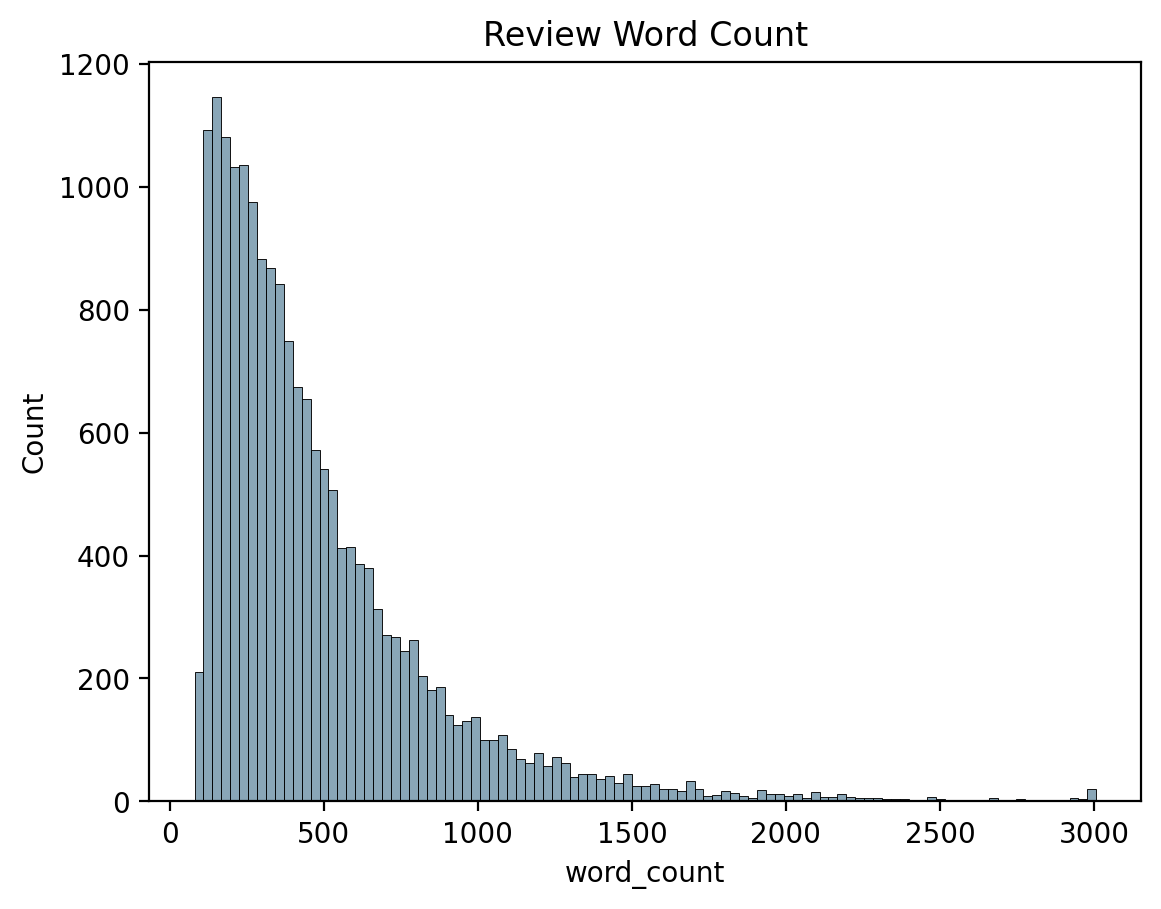

In [164]:
sns.histplot(data['word_count'], color="#62899f")
plt.title("Review Word Count")

In [165]:
data['visited_date'].min()

Timestamp('2022-01-01 00:00:00')

In [166]:
ts = TimeSeriesHelper()

In [167]:
data_ts = ts.to_timeseries(data, 'visited_date', 'ode', 'M', 'count')

visited_date
2022-01-31     398
2022-02-28     402
2022-03-31     500
2022-04-30     424
2022-05-31     530
2022-06-30     565
2022-07-31     548
2022-08-31     573
2022-09-30     604
2022-10-31     729
2022-11-30     731
2022-12-31     692
2023-01-31     965
2023-02-28     885
2023-03-31    1142
2023-04-30     880
2023-05-31     944
2023-06-30    1000
2023-07-31     904
2023-08-31     885
2023-09-30     766
2023-10-31    1041
2023-11-30     983
2023-12-31     812
2024-01-31     558
Freq: M, Name: ode, dtype: int64

In [168]:
data_ts

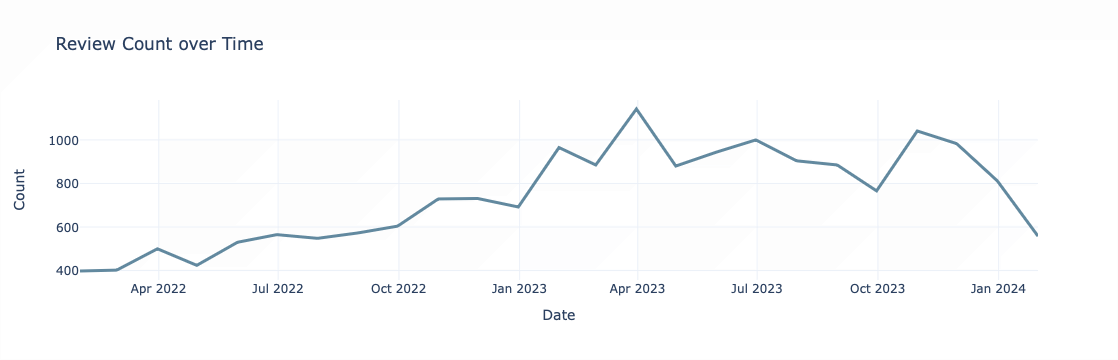

In [169]:
ts.plot_timeseries(package='plotly', figsize=(16, 4), title='Review Count over Time', color='#62899f', line_thickness=3)

# Exploratory Analysis